# Evolutionary model of Lund et al. 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## RSA Model from Lund et al. 2019

In [2]:
#powerset helper function
def powerset(s):
    if len(s)==0: #base case
        return [[]]
    else:
        r = powerset(s[:-1])
        element = [s[-1]]
        new_r = r + list(map(lambda x: x+element, r))
        return new_r

### Define inital parameters

Build world states, etc.

In [3]:
class InitialParams:
    def __init__(self, n_events=5, n_bins=2, possible_thetas=[0.4,0.5,0.6,0.7,0.8,0.9,1], no_singles=True):
        self.n_events = n_events
        self.n_bins = n_bins
        self.possible_thetas = possible_thetas
        self.no_singles = no_singles
    
    def generate_events(self, n_events):
        bin_size = 1 / n_events
        eventPop = map(lambda x:round(((bin_size/2)+(bin_size*x))*100)/100, range(n_events))
        return list(eventPop)
    
    def generate_states(self, n_events):
        events = self.generate_events(n_events)
        states = list(filter(lambda x:len(x)>0, powerset(events)))
        if self.no_singles == True:
            states = list(filter(lambda x:len(x)>1, states))
        return states
    
    def generate_state_prior(self, states):
        indices = [str(state) for state in states]
        return pd.Series(np.ones(len(states))/len(states), index=indices)
    
    #Generate ordered pair <thetaR, thetaImpf> s.t. thetaImpf is greater than or equal to thetaR
    def generate_thetas(self, thetas):
        return [(a, b) for a in thetas for b in thetas if b>=a]

    def generate_thetas_prior(self, thetas):
        indices = [str(theta) for theta in thetas]
        return pd.Series(np.ones(len(thetas))/len(thetas), index=indices)
    
    def theta_bins(number_bins, theta):
        new_bins = [0]
        bin_size = theta / number_bins
        bin_array = range(0, number_bins)
        bin_pop = list(map(lambda x:bin_size + bin_size*x, bin_array))
        return new_bins+bin_pop
    
    def make_params(self):
        self.states = self.generate_states(self.n_events)
        self.state_prior = self.generate_state_prior(self.states)
        self.thetas = self.generate_thetas(self.possible_thetas)
        self.thetas_prior = self.generate_thetas_prior(self.thetas)
        return self

### Define the RSA model

In [4]:
class RSA_model:
    utterances = ["prog", "impf", "null"]
    
    def __init__(self, costs, thetas, thetas_prior, states, state_prior, n_bins=2, alpha=1):
        self.costs = costs
        self.thetas = thetas
        self.thetas_prior = thetas_prior
        self.thetas_prior_dict = {x: y for x in thetas for y in thetas_prior}
        self.states = states
        self.state_prior = state_prior
        self.n_bins = n_bins
        self.alpha = alpha
        self.state_names = {str(x):x for x in states}
    
    def meaning(self, utterance, bins_r, bins_t, state):
        if utterance == "prog":
            return self.meaning_function(state, bins_r, 0)
        elif utterance == "impf":
            return self.meaning_function(state, bins_t, 0)
        else:
            return 1
    
    def meaning_function(self, state, bins, counter=0):
        if counter==len(bins)-1:
            return 1
        elif any(map(lambda x:x>bins[counter] and x<=bins[counter+1], state)):
            return self.meaning_function(state, bins, counter+1)
        else:
            return 0
    
    def theta_bins(self, number_bins, theta):
        new_bins = [0]
        bin_size = theta / number_bins
        bin_array = range(0, number_bins)
        bin_pop = list(map(lambda x:bin_size + bin_size*x, bin_array))
        return new_bins+bin_pop
    
    def literal_listener(self, theta_r, theta_t):
        """
        Returns a probability distribution over world states as a stochastic row matrix.
        """
        bins_r = self.theta_bins(self.n_bins, theta_r)
        bins_t = self.theta_bins(self.n_bins, theta_t)
        columns = [str(x) for x in self.states]
        truth_values = pd.DataFrame(index=self.utterances, columns=columns, dtype=float)
        for r in self.utterances:
            for c in columns:
                truth_values.loc[r, c] = self.meaning(r, bins_r, bins_t, self.state_names[c])
        truth_values = truth_values * self.state_prior
        row_sum = truth_values.sum(axis=1)
        distribution = truth_values.div(row_sum, axis=0)
        return distribution
    
    def utility(self, L1_probs):
        with np.errstate(divide='ignore'):
            return L1_probs.apply(lambda x:np.exp(self.alpha * (np.log(x) - self.costs[x.name])), axis=1)
    
    def speaker(self, theta_r, theta_t):
        L1 = self.literal_listener(theta_r, theta_t)
        return self.utility(L1).apply(lambda x:x / np.sum(x)).T
    
    def pragmatic_listener(self):
        S1 = {x: self.speaker(x[0], x[1]) * self.thetas_prior_dict[x] for x in self.thetas} # Dict of theta, speaker pairs.
        S1 = np.multiply(sum(S1.values()), np.array(self.state_prior).reshape(len(self.state_prior),1)) #apply state priors
        S1_row_sum = S1.T.sum(axis=1)
        utterance_dist = S1.T.div(S1_row_sum, axis=0)
        return utterance_dist
    
    def pragmatic_listener_I(self, theta_r, theta_t):
        S1 = self.speaker(theta_r, theta_t)
        S1 = np.multiply(S1, np.array(self.state_prior).reshape(len(self.state_prior),1)) #apply state priors
        S1_row_sum = S1.T.sum(axis=1)
        L1 = S1.T.div(S1_row_sum, axis=0)
        return L1      
    
    def pragmatic_speaker(self):
        """
        This is getting slightly different numbers than the webppl version
        and I can't for the life of me figure out why. The math is the same!
        It must be something with log because the numbers are very close,
        I can't get different numbers otherwise, and the pragmatic listener
        is returning the same results as the webppl model.
        """
        L1 = {x: self.pragmatic_listener_I(x[0], x[1]) * self.thetas_prior_dict[x] for x in self.thetas}
        L1 = sum(L1.values())
        U = self.utility(L1).T
        U_row_sum = U.sum(axis=1)
        S2 = U.div(U_row_sum, axis=0)
        return S2    

In [5]:
params = InitialParams()
params.make_params()

costs = {'prog': 1, 'impf': 1, 'null': 100}

RSA = RSA_model(costs, params.thetas, params.thetas_prior, params.states, params.state_prior)
RSA.pragmatic_speaker()

,prog,impf,null
"[0.1, 0.3]",0.869066,0.130934,1.854639e-43
"[0.1, 0.5]",0.566362,0.433638,2.208452e-44
"[0.3, 0.5]",0.473130,0.526870,5.681776e-44
"[0.1, 0.3, 0.5]",0.702890,0.297110,5.990942e-45
"[0.1, 0.7]",0.274501,0.725499,2.547722e-44
"[0.3, 0.7]",0.274501,0.725499,2.547722e-44
"[0.1, 0.3, 0.7]",0.603353,0.396647,2.309010e-45
"[0.5, 0.7]",0.090819,0.909181,5.904449e-43
"[0.1, 0.5, 0.7]",0.487303,0.512697,2.003454e-45
"[0.3, 0.5, 0.7]",0.385260,0.614740,8.418864e-45


In [25]:
S = RSA.pragmatic_speaker()
L = RSA.pragmatic_listener()

S.loc['[0.1, 0.3]'].round(3)

prog    0.869
impf    0.131
null    0.000
Name: [0.1, 0.3], dtype: float64

## Evolutionary model

Now that we have models for speakers and listeners, we can build an evolutionary model.

### The utility function

#### $\delta$-function

Unlike the $\delta$-function in Jäger 2007 and Deo 2015, our function will differ in that the speaker and listener models are not deterministic. They return probabilities over utterances and world states. 

For now, we'll just return the probability that the listener picks up the given world state from the speaker. This is maybe naive and we might want to come up with some kind of notion of partial success where the world states are similar but not the same.

**Update:**

Another possibility is that states that partially overlap *do* contribute to the score, but only partially. To do this, we would take the symmetric difference of the input state and the considered state. That would be the input to some function $f(x)$ with codomain $[0,1]$ and multiply that by the probability the listener chooses the considered state. If the two sets are identical, $f$ returns 1 for no penalty. The value of $f(x)$ decreases as the symmetric difference increases. Not sure what shape $f$ should have, but I'll use the following for now, where $n$ is the maximum the sets can differ:

$$f(x) = 1 - \left(\frac{x}{n}\right)^{\frac{1}{4}}$$

This implemented in `U_2`.


#### Utility function

This is easy to compute; we just do matrix multiplication of the $S$ matrix and the $L$ matrix. The result is a matrix where the rows are the world state inputs to S and the columns are the average that L is going to guess the world state in that column.

To get a vector representing delta over all world states, we take the diagonal of the matrix. This is the probability that the listener will correctly pick up on the same world state that the speaker receives.

The average utility across states, then, will just be the sum of that vector.

$$U(S, L) = \sum_i diag(SL)_i$$

**Update:**

Or see the alternative above.

### Expected utility

We can just borrow this from Deo 2015.

$$\text{EU}(\langle S, H\rangle, \langle S', H'\rangle) = \frac{1}{2} \times (U_s(S, H') + U_h(S', H))$$

This is what we'll use to create the payoff matrix.

In [30]:
state_names = {str(x):x for x in params.states}
df = pd.DataFrame(index=state_names, columns=state_names)
f = lambda x: -(np.log(x+1) / np.log(5 + 1)) + 1
for s1 in params.states:
    for s2 in params.states:
        df.loc[str(s1), str(s2)] = f(len(set(s1) ^ set(s2)))
        
np.multiply((S @ L), df).sum(axis=1).sum()

9.555769962004902

In [109]:
a = L.T.dot(S.loc['[0.1, 0.3]']).loc['[0.1, 0.3]']
b = L.T.dot(S.loc['[0.1, 0.3, 0.5]']).loc['[0.1, 0.3, 0.5]']
np.diagonal((S @ L)).sum()

1.638135053956745

In [178]:
class AverageUtility:
    def __init__(self, strategies, params, alt_U=False):
        self.strategies = strategies
        self.thetas = params.thetas
        self.thetas_prior = params.thetas_prior
        self.states = params.states
        self.state_prior = params.state_prior
        self.alt_U=alt_U
        self.strat_models = None
        self.strat_form_probs = None
        self.EU_matrix = None
        
    def make_models(self):
        strat_models = {}
        for k in self.strategies:
            model = RSA_model(self.strategies[k], self.thetas, self.thetas_prior, self.states, self.state_prior)
            S = model.pragmatic_speaker()
            L = model.pragmatic_listener()
            strat_models[k] = {'S': S, 'L': L}
        self.strat_models=strat_models
        self.set_strat_form_probs()
        return self
    
    def set_strat_form_probs(self):
        strat_forms = pd.DataFrame(index = self.strat_models.keys(), columns=['impf', 'prog', 'null'])
        for strat in self.strat_models.keys():
            strat_forms.loc[strat] = self.strat_models[strat]['S'].sum() / sum(self.strat_models[strat]['S'].sum())
        self.strat_form_probs = strat_forms
        return self
    
    #(actually we don't need this, but I'm leaving it here in case it makes more sense.)
    def delta(self, S, L, t):
        # Get the average time each state will be guessed given an utterance
        # (that's the dot product) and then take the result from that state
        return L.T.dot(S.loc[t]).loc[t]
    
    def U(self, S, L):
        return np.diagonal(S @ L).sum()
    
    def U_2(self, S, L):
        state_names = {str(x):x for x in self.states}
        weights = pd.DataFrame(index=state_names, columns=state_names)
        for s1 in params.states:
            for s2 in params.states:
                weights.loc[str(s1), str(s2)] = len(set(s1) ^ set(s2))
        f = lambda x: 1 - (x / weights.max().max()) ** 0.25
        weights.applymap(f)
        return np.multiply((S @ L), weights).sum(axis=1).sum()
    
    def EU(self, S1, L1, S2, L2):
        if self.alt_U:
            return 0.5 * (self.U_2(S1, L2) + self.U_2(S2, L1))
        else:
            return 0.5 * (self.U(S1, L2) + self.U(S2, L1))
    
    def make_EU_matrix(self):
        self.make_models()
        strategies = list(self.strategies.keys())
        matrix = pd.DataFrame(np.zeros((len(strategies), len(strategies))),
                              index=strategies, 
                              columns=strategies)
        for strat1 in strategies:
            for strat2 in strategies:
                matrix.loc[strat1, strat2] = self.EU(self.strat_models[strat1]['S'], self.strat_models[strat1]['L'], self.strat_models[strat2]['S'], self.strat_models[strat2]['L'])
        self.EU_matrix = matrix
        return self

### Dynamics

Now that we have our payoff matrix we can just use the exact same replicator-mutator dynamics as in Deo 2015.

We'll also build in functionality to get the average form use over time.

In [32]:
class ReplicatorMutatorDynamics:
    def __init__(self, au_object, frequencies, Q):
        self.au = au_object
        self.au.make_EU_matrix()
        self.strat_form_probs = self.au.strat_form_probs
        self.payoffs = self.au.EU_matrix
        self.frequencies = frequencies
        self.Q = Q
        self.model = None
        self.forms_over_time = None
    
    def avg_form_use(self):
        self.forms_over_time = (self.strat_form_probs.T @ self.model.T).T
        return self
    
    def replicator(self, payoffs, frequencies):
        average_payoffs = payoffs.dot(frequencies)
        average_fitness = average_payoffs.dot(frequencies)
        new_population = frequencies * average_payoffs / average_fitness
        return new_population
    
    def replicator_mutator(self, payoffs, frequencies, Q):
        average_payoffs = payoffs.dot(frequencies)
        average_fitness = average_payoffs.dot(frequencies)
        new_population = Q.T.dot(frequencies * average_payoffs) / average_fitness
        return new_population
    
    def run_dynamics(self, iterations):
        iteration = 0
        init_frequencies = self.frequencies
        payoffs = self.payoffs
        Q = self.Q
        frequencies = init_frequencies
        results = pd.DataFrame(index=range(0, iterations+1), columns=payoffs.columns)
        results.iloc[[0]] = np.zeros((1, len(payoffs.columns)))
        for i in range(iteration, iterations+1):
            frequencies = self.replicator_mutator(payoffs, frequencies, Q)
            results.iloc[i, :] = frequencies
        self.model = results
        self.avg_form_use()
        return self

# Average form use over time

Get the average usage of a form for the pragmatic speaker of strategy:

$$\alpha_{s,u} = \frac{\sum_t S_1(u|t)}{\sum_u{\sum_t S_1(u|t)}}$$

Average use of a form at time $t$, where $f_{s,t}$ is the proportion of a strategy at time $t$.

$$\beta_{u,t} = \frac{\sum_s \alpha_{s,u}f_{s,t}}{\sum_u\sum_s \alpha_{s,u}f_{s,t}}$$

If $A$ is a matrix of strategies and forms, $|S| \times |U|$, and $T_t$ is a vector of strategies and their respective proportions at a time $t$, the average that a form will be used at $t$ is the dot product:

$$A^\intercal\cdot T$$

In the case of the entire model we can generalize from the dot product to matrix multiplication, $M$ is a matrix of times and strategy proportions:

$$A^\intercal M^\intercal$$

Which gives us the average a form will be used at each point in the model. This is defined in the `MutatorReplicatorDynamics` class in the `avg_form_use` function.

# Experiments

## Exp 1

In [33]:
strategies7 = {'s1': {'prog':7, 'impf':1, 'null':100},
             's2': {'prog':5, 'impf':1, 'null':100},
             's3': {'prog':3, 'impf':1, 'null':100},
             's4': {'prog':1, 'impf':1, 'null':100},
             's5': {'prog':1, 'impf':3, 'null':100},
             's6': {'prog':1, 'impf':5, 'null':100},
             's7': {'prog':1, 'impf':7, 'null':100}}

au7 = AverageUtility(strategies7, params)

frequencies7 = np.array([0.91, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01])
Q7 = np.array([[1, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 1]])
model7 = ReplicatorMutatorDynamics(au7, frequencies7, Q7)
model7.run_dynamics(2600)

<AxesSubplot:>

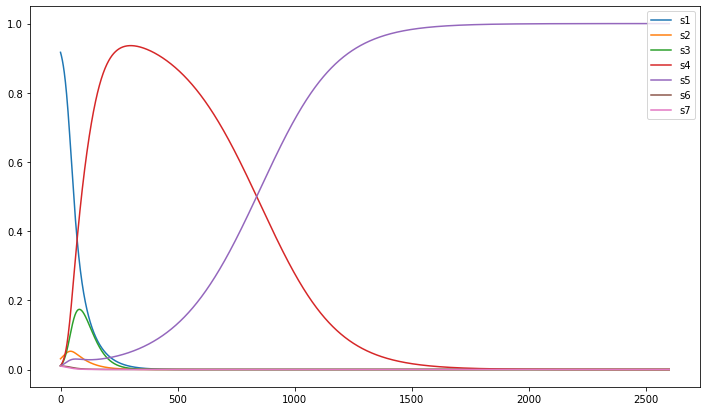

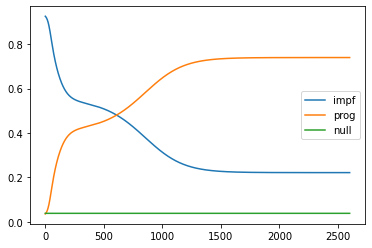

In [35]:
plt.figure(figsize=(12, 7))
plt.plot(model7.model)
plt.legend(strategies7.keys(), loc='upper right')

model7.forms_over_time.plot()

In [36]:
# Same as above but with the alternative U.

au7_u = AverageUtility(strategies7, params, alt_U=True)

model7_u = ReplicatorMutatorDynamics(au7_u, frequencies7, Q7)
model7_u.run_dynamics(2600)

In [38]:
au7_u.EU_matrix

,s1,s2,s3,s4,s5,s6,s7
s1,61.540957,61.381081,61.066256,61.183315,62.175379,62.996202,63.302580
s2,61.381081,61.266043,61.045800,61.141993,62.006722,62.739298,63.010743
s3,61.066256,61.045800,61.008518,60.978148,61.449959,61.932412,62.109993
s4,61.183315,61.141993,60.978148,60.520085,60.429326,60.667337,60.779871
s5,62.175379,62.006722,61.449959,60.429326,59.980690,60.180940,60.303549
s6,62.996202,62.739298,61.932412,60.667337,60.180940,60.431727,60.573920
s7,63.302580,63.010743,62.109993,60.779871,60.303549,60.573920,60.721677


In [39]:
au7.EU_matrix

,s1,s2,s3,s4,s5,s6,s7
s1,1.161409,1.190951,1.250043,1.259954,1.202418,1.162447,1.150793
s2,1.190951,1.211071,1.249392,1.254923,1.204852,1.167663,1.156540
s3,1.250043,1.249392,1.243868,1.246719,1.220840,1.191827,1.182044
s4,1.259954,1.254923,1.246719,1.276413,1.283119,1.260004,1.249686
s5,1.202418,1.204852,1.220840,1.283119,1.291262,1.252491,1.235947
s6,1.162447,1.167663,1.191827,1.260004,1.252491,1.198995,1.178193
s7,1.150793,1.156540,1.182044,1.249686,1.235947,1.178193,1.156329


<AxesSubplot:>

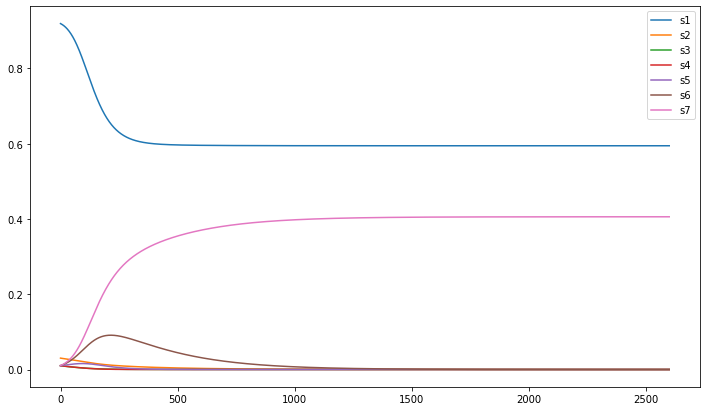

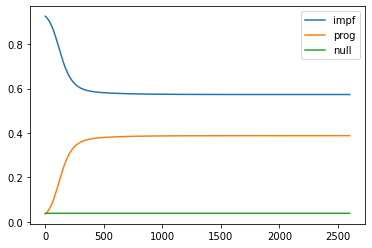

In [37]:
plt.figure(figsize=(12, 7))
plt.plot(model7_u.model)
plt.legend(strategies7.keys(), loc='upper right')

model7_u.forms_over_time.plot()

## Exp 2

In [72]:
frequenciesm = np.array([1, 0, 0, 0, 0, 0, 0])
Qm = np.array([[0.99, 0.01, 0, 0, 0, 0, 0],
              [0.02, 0.97, 0.01, 0, 0, 0, 0],
              [0, 0.1, 0.98, 0.01, 0, 0, 0],
              [0, 0, 0.0, 0.99, 0.01, 0, 0],
              [0, 0, 0, 0.0, 0.98, 0.02, 0],
              [0, 0, 0, 0, 0.0, 0.97, 0.03],
              [0, 0, 0, 0, 0, 0.0, 1]])

aum = AverageUtility(strategies7, params)
modelm = ReplicatorMutatorDynamics(aum, frequenciesm, Qm)
modelm.run_dynamics(1000)

<AxesSubplot:>

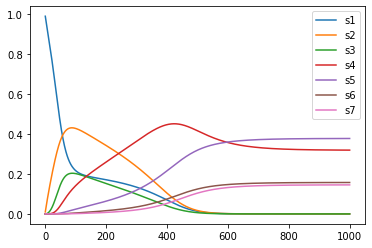

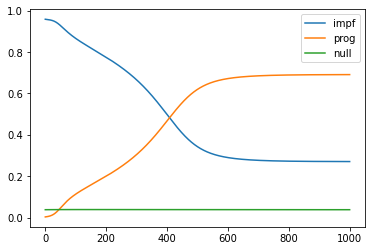

In [73]:
modelm.model.plot()

modelm.forms_over_time.plot()

## Exp 3

In [179]:
strategies7 = {'s1': {'prog':10, 'impf':1, 'null':100},
             's2': {'prog':7, 'impf':1, 'null':100},
             's3': {'prog':4, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':1, 'null':100},
              's5': {'prog':1, 'impf':4, 'null':100},
              's6': {'prog':1, 'impf':7, 'null':100},
              's7': {'prog':1, 'impf':10, 'null':100}}

aum = AverageUtility(strategies7, params, alt_U=True)

In [180]:
frequenciesm = np.array([1, 0, 0, 0, 0, 0, 0])
Qm = np.array([[0.99, 0.01, 0, 0, 0, 0, 0],
              [0.0, 0.99, 0.01, 0, 0, 0, 0],
              [0, 0.0, 0.99, 0.01, 0, 0, 0],
              [0, 0, 0.0, 0.98, 0.02, 0, 0],
              [0, 0, 0, 0.0, 0.99, 0.01, 0],
              [0, 0, 0, 0, 0.0, 0.99, 0.01],
              [0, 0, 0, 0, 0, 0.0, 1]])

modelm = ReplicatorMutatorDynamics(aum, frequenciesm, Qm)
modelm.run_dynamics(2000)

<AxesSubplot:>

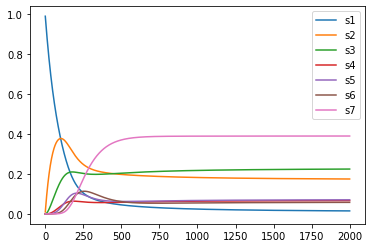

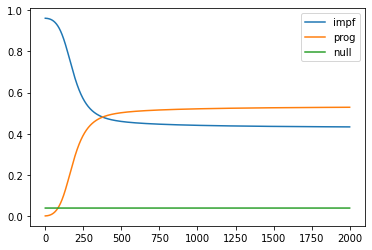

In [181]:
modelm.model.plot()

modelm.forms_over_time.plot()

## Exp 4

In [340]:
strategies2 = {'s1': {'prog':3, 'impf':1, 'null':100},
             's2': {'prog':2, 'impf':1, 'null':100},
             's3': {'prog':1, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':2, 'null':100},
              's5': {'prog':1, 'impf':3, 'null':100}}

au2 = AverageUtility(strategies2, params)

frequencies2 = np.array([0.96, 0.01, 0.01, 0.01, 0.01])
Q2 = np.diag(np.ones(len(frequencies2)))
model2 = ReplicatorMutatorDynamics(au2, frequencies2, Q2)
model2.run_dynamics(2300)

<AxesSubplot:>

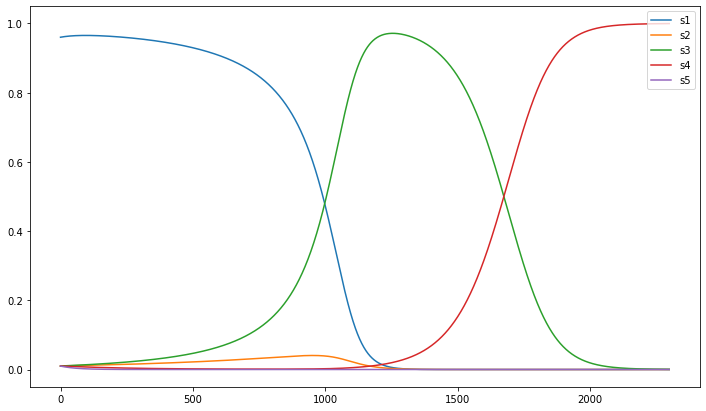

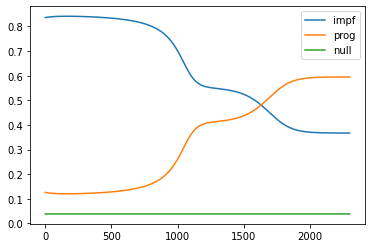

In [347]:
plt.figure(figsize=(12, 7))
plt.plot(model2.model)
plt.legend(strategies2.keys(), loc='upper right')

model2.forms_over_time.plot()

In [70]:
strategies2 = {'s1': {'prog':3, 'impf':1, 'null':100},
             's2': {'prog':2, 'impf':1, 'null':100},
             's3': {'prog':1, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':2, 'null':100},
              's5': {'prog':1, 'impf':3, 'null':100}}

au2_u = AverageUtility(strategies2, params, alt_U=True)

In [ ]:
frequencies2 = np.array([0.98, 0.02, 0, 0, 0])
Q2 = np.array([[0.99, 0.01, 0, 0, 0],
              [0.01, 0.98, 0.01, 0, 0],
              [0, 0.01, 0.96, 0.03, 0],
              [0, 0, 0.0, 0.96, 0.04],
              [0, 0, 0, 0, 1]])
model2_u = ReplicatorMutatorDynamics(au2_u, frequencies2, Q2)
model2_u.run_dynamics(700)

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(model2_u.model)
plt.legend(strategies2.keys(), loc='upper right')

model2_u.forms_over_time.plot()

In [415]:
strategies3 = {'s1': {'prog':2, 'impf':1, 'null':100},
             's2': {'prog':1.5, 'impf':1, 'null':100},
             's3': {'prog':1, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':1.5, 'null':100},
              's5': {'prog':1, 'impf':2, 'null':100}}

au3 = AverageUtility(strategies3, params)

frequencies3 = np.array([0.978, 0.01, 0.01, 0.001, 0.001])
# Q3 = np.array([[1, 0.0, 0, 0, 0],
#               [0, 1, 0, 0, 0],
#               [0, 0.01, 0.98, 0.01, 0],
#               [0, 0, 0.01, 0.98, 0.01],
#               [0, 0, 0, 0.1, 0.99]])
Q3 = np.diag(np.ones(len(frequencies)))
model3 = ReplicatorMutatorDynamics(au3, frequencies3, Q3)
model3.run_dynamics(2300)

<AxesSubplot:>

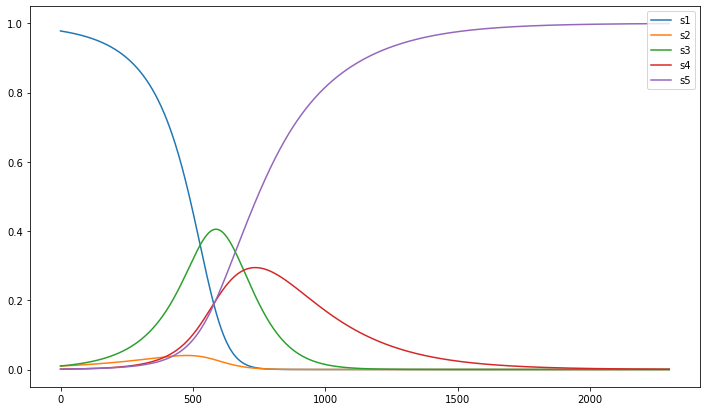

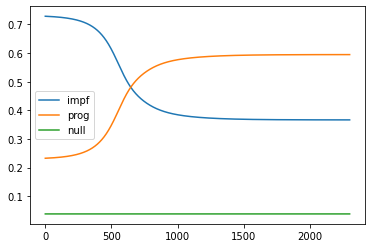

In [416]:
plt.figure(figsize=(12, 7))
plt.plot(model3.model)
plt.legend(strategies.keys(), loc='upper right')

model3.forms_over_time.plot()

In [408]:
au3.EU_matrix

,s1,s2,s3,s4,s5
s1,1.149430,1.186858,1.260731,1.233495,1.201992
s2,1.186858,1.211071,1.254923,1.232440,1.204852
s3,1.260731,1.254923,1.276413,1.287289,1.283119
s4,1.233495,1.232440,1.287289,1.303968,1.300032
s5,1.201992,1.204852,1.283119,1.300032,1.291262


## Does simply having more states affect the relative proportions of prog and impf?

In [88]:
strategies1 = {'s1': {'prog':2, 'impf':1, 'null':100},
             's2': {'prog':1, 'impf':1, 'null':100},
             's3': {'prog':1, 'impf':2, 'null':100}}

strategies2 = {'s1': {'prog':3, 'impf':1, 'null':100},
             's2': {'prog':2, 'impf':1, 'null':100},
             's3': {'prog':1, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':2, 'null':100},
              's5': {'prog':1, 'impf':3, 'null':100}}

strategies3 = {'s1': {'prog':4, 'impf':1, 'null':100},
             's2': {'prog':3, 'impf':1, 'null':100},
             's3': {'prog':2, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':1, 'null':100},
              's5': {'prog':1, 'impf':2, 'null':100},
              's6': {'prog':1, 'impf':3, 'null':100},
              's7': {'prog':1, 'impf':4, 'null':100}}

au1 = AverageUtility(strategies1, params, alt_U=True)
au2 = AverageUtility(strategies2, params, alt_U=True)
au3 = AverageUtility(strategies3, params, alt_U=True)


frequencies1 = np.array([0.96, 0.01, 0.01])
Q1 = np.diag(np.ones(len(frequencies1)))
model1 = ReplicatorMutatorDynamics(au1, frequencies1, Q1)
model1.run_dynamics(1000)

frequencies2 = np.array([0.96, 0.01, 0.01, 0.01, 0.01])
Q2 = np.diag(np.ones(len(frequencies2)))
model2 = ReplicatorMutatorDynamics(au2, frequencies2, Q2)
model2.run_dynamics(1000)

frequencies3 = np.array([0.96, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
Q3 = np.diag(np.ones(len(frequencies3)))
model3 = ReplicatorMutatorDynamics(au3, frequencies3, Q3)
model3.run_dynamics(1000)

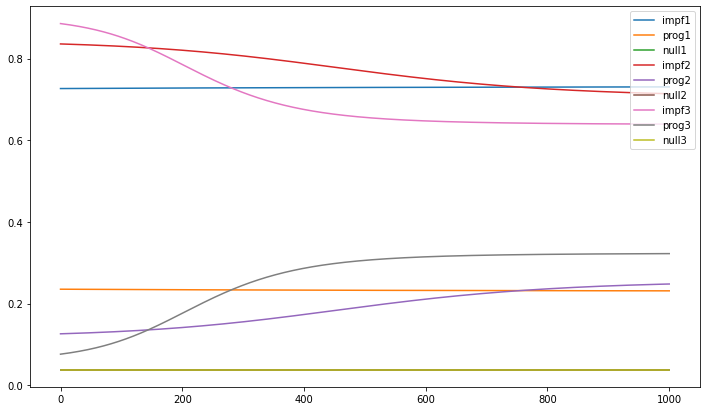

In [93]:
# plt.figure(figsize=(12, 7))
# plt.plot(model2.model)
# plt.legend(strategies2.keys(), loc='upper right')

plt.figure(figsize=(12, 7))
plt.plot(model1.forms_over_time)
plt.plot(model2.forms_over_time)
plt.plot(model3.forms_over_time)
plt.legend(['impf1', 'prog1', 'null1', 'impf2', 'prog2', 'null2', 'impf3', 'prog3', 'null3'], loc='upper right')


So, yes, the number of states absolutely affects it, but maybe only because the costs are wider apart.

## What happens when the costs are much higher?

In [99]:
strategies1 = {'s1': {'prog':4, 'impf':1, 'null':100},
             's2': {'prog':3, 'impf':1, 'null':100},
             's3': {'prog':2, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':1, 'null':100},
              's5': {'prog':1, 'impf':2, 'null':100},
              's6': {'prog':1, 'impf':3, 'null':100},
              's7': {'prog':1, 'impf':4, 'null':100}}

strategies2 = {'s1': {'prog':7, 'impf':1, 'null':100},
             's2': {'prog':5, 'impf':1, 'null':100},
             's3': {'prog':3, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':1, 'null':100},
              's5': {'prog':1, 'impf':3, 'null':100},
              's6': {'prog':1, 'impf':5, 'null':100},
              's7': {'prog':1, 'impf':7, 'null':100}}

strategies3 = {'s1': {'prog':10, 'impf':1, 'null':100},
             's2': {'prog': 7, 'impf':1, 'null':100},
             's3': {'prog':4, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':1, 'null':100},
              's5': {'prog':1, 'impf':4, 'null':100},
              's6': {'prog':1, 'impf':7, 'null':100},
              's7': {'prog':1, 'impf':10, 'null':100}}

au1 = AverageUtility(strategies1, params, alt_U=True)
au2 = AverageUtility(strategies2, params, alt_U=True)
au3 = AverageUtility(strategies3, params, alt_U=True)

frequencies1 = np.array([0.96, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
Q1 = np.diag(np.ones(len(frequencies1)))
model1 = ReplicatorMutatorDynamics(au1, frequencies1, Q1)
model1.run_dynamics(1000)

frequencies2 = np.array([0.96, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
Q2 = np.diag(np.ones(len(frequencies2)))
model2 = ReplicatorMutatorDynamics(au2, frequencies2, Q2)
model2.run_dynamics(1000)

frequencies3 = np.array([0.96, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
Q3 = np.diag(np.ones(len(frequencies3)))
model3 = ReplicatorMutatorDynamics(au3, frequencies3, Q3)
model3.run_dynamics(1000)

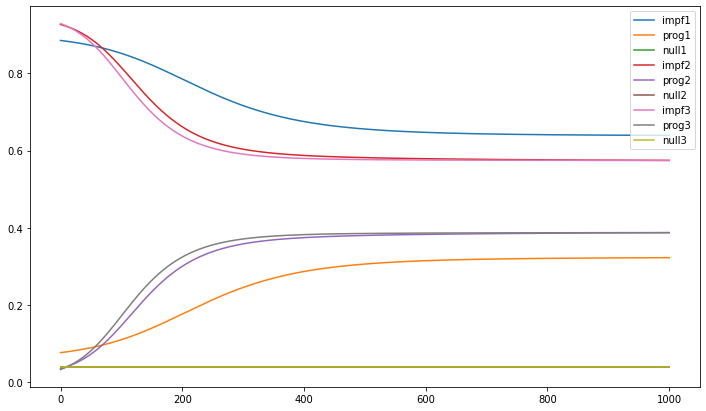

In [100]:
# plt.figure(figsize=(12, 7))
# plt.plot(model2.model)
# plt.legend(strategies2.keys(), loc='upper right')

plt.figure(figsize=(12, 7))
plt.plot(model1.forms_over_time)
plt.plot(model2.forms_over_time)
plt.plot(model3.forms_over_time)
plt.legend(['impf1', 'prog1', 'null1', 'impf2', 'prog2', 'null2', 'impf3', 'prog3', 'null3'], loc='upper right')


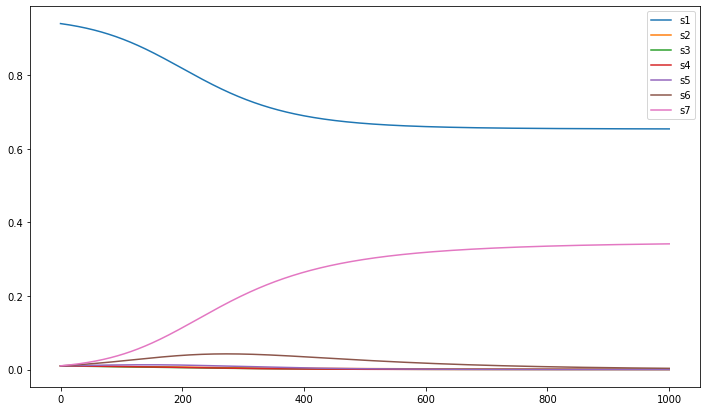

In [101]:
plt.figure(figsize=(12, 7))
plt.plot(model1.model)
plt.legend(strategies1.keys(), loc='upper right')

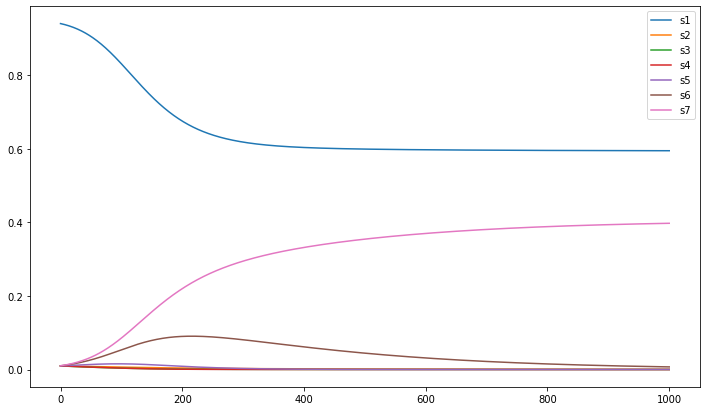

In [102]:
plt.figure(figsize=(12, 7))
plt.plot(model2.model)
plt.legend(strategies2.keys(), loc='upper right')

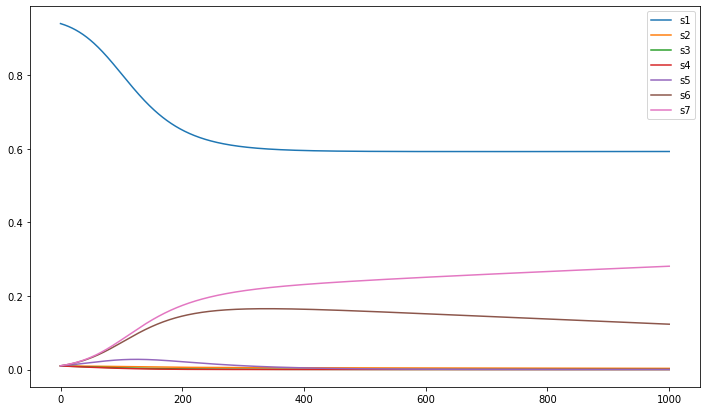

In [103]:
plt.figure(figsize=(12, 7))
plt.plot(model3.model)
plt.legend(strategies3.keys(), loc='upper right')

### Same thing with mutator

In [182]:
strategies1 = {'s1': {'prog':4, 'impf':1, 'null':100},
             's2': {'prog':3, 'impf':1, 'null':100},
             's3': {'prog':2, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':1, 'null':100},
              's5': {'prog':1, 'impf':2, 'null':100},
              's6': {'prog':1, 'impf':3, 'null':100},
              's7': {'prog':1, 'impf':4, 'null':100}}

strategies2 = {'s1': {'prog':7, 'impf':1, 'null':100},
             's2': {'prog':5, 'impf':1, 'null':100},
             's3': {'prog':3, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':1, 'null':100},
              's5': {'prog':1, 'impf':3, 'null':100},
              's6': {'prog':1, 'impf':5, 'null':100},
              's7': {'prog':1, 'impf':7, 'null':100}}

strategies3 = {'s1': {'prog':10, 'impf':1, 'null':100},
             's2': {'prog': 7, 'impf':1, 'null':100},
             's3': {'prog':4, 'impf':1, 'null':100},
              's4': {'prog':1, 'impf':1, 'null':100},
              's5': {'prog':1, 'impf':4, 'null':100},
              's6': {'prog':1, 'impf':7, 'null':100},
              's7': {'prog':1, 'impf':10, 'null':100}}

au1 = AverageUtility(strategies1, params, alt_U=True)
au2 = AverageUtility(strategies2, params, alt_U=True)
au3 = AverageUtility(strategies3, params, alt_U=True)

frequenciesm = np.array([1, 0, 0, 0, 0, 0, 0])
# Qm = np.array([[0.99, 0.01, 0, 0, 0, 0, 0],
#               [0.0, 0.99, 0.01, 0, 0, 0, 0],
#               [0, 0.0, 0.99, 0.01, 0, 0, 0],
#               [0, 0, 0.0, 0.99, 0.01, 0, 0],
#               [0, 0, 0, 0.0, 0.99, 0.01, 0],
#               [0, 0, 0, 0, 0.0, 0.99, 0.01],
#               [0, 0, 0, 0, 0, 0.0, 1]])

Qm = np.array([[0.99, 0.01, 0, 0, 0, 0, 0],
              [0.02, 0.97, 0.01, 0, 0, 0, 0],
              [0, 0.1, 0.98, 0.01, 0, 0, 0],
              [0, 0, 0.0, 0.99, 0.01, 0, 0],
              [0, 0, 0, 0.0, 0.98, 0.02, 0],
              [0, 0, 0, 0, 0.0, 0.97, 0.03],
              [0, 0, 0, 0, 0, 0.0, 1]])

model1 = ReplicatorMutatorDynamics(au1, frequenciesm, Qm)
model1.run_dynamics(600)

model2 = ReplicatorMutatorDynamics(au2, frequenciesm, Qm)
model2.run_dynamics(600)

model3 = ReplicatorMutatorDynamics(au3, frequenciesm, Qm)
model3.run_dynamics(600)

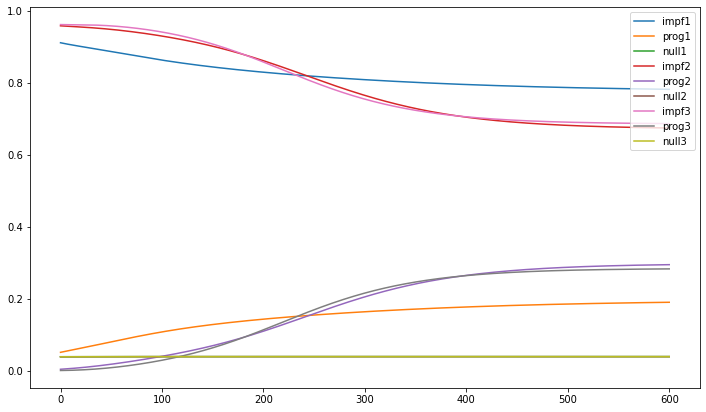

In [183]:
# plt.figure(figsize=(12, 7))
# plt.plot(model2.model)
# plt.legend(strategies2.keys(), loc='upper right')

plt.figure(figsize=(12, 7))
plt.plot(model1.forms_over_time)
plt.plot(model2.forms_over_time)
plt.plot(model3.forms_over_time)
plt.legend(['impf1', 'prog1', 'null1', 'impf2', 'prog2', 'null2', 'impf3', 'prog3', 'null3'], loc='upper right')


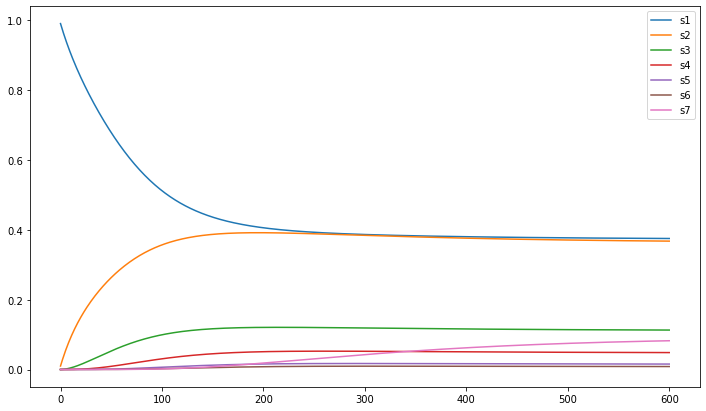

In [184]:
plt.figure(figsize=(12, 7))
plt.plot(model1.model)
plt.legend(strategies1.keys(), loc='upper right')

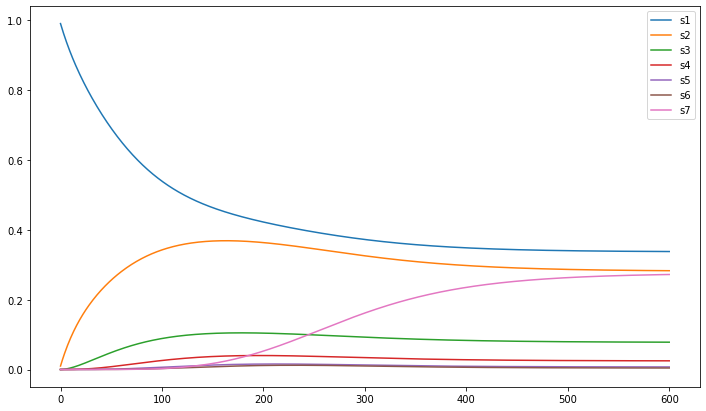

In [185]:
plt.figure(figsize=(12, 7))
plt.plot(model2.model)
plt.legend(strategies2.keys(), loc='upper right')

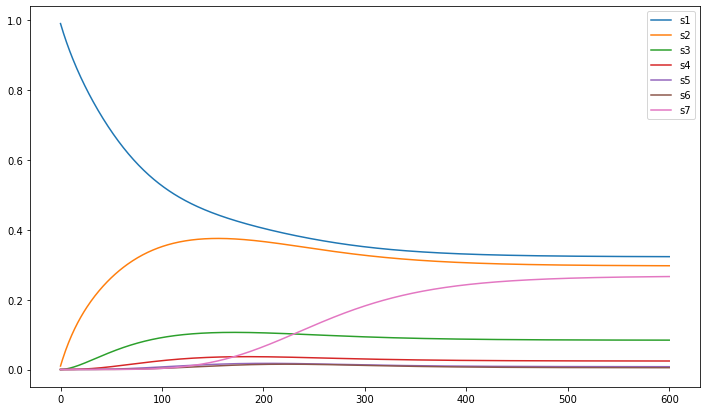

In [186]:
plt.figure(figsize=(12, 7))
plt.plot(model3.model)
plt.legend(strategies3.keys(), loc='upper right')